In [4]:
import IPython.display as ipd
 #loading sample audio t hear it

ipd.Audio('sample audio/1-137-A-32.wav')


In [5]:
ipd.Audio('sample audio/1-9887-B-49.wav')

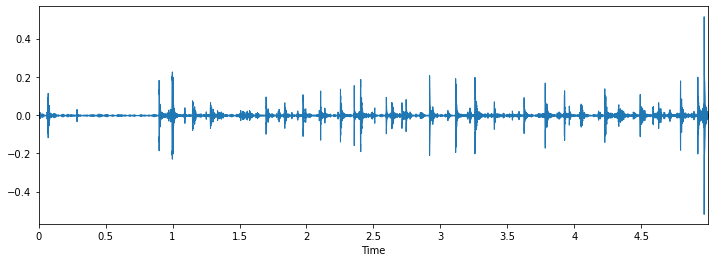

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# loading sample audio to visualize its patterns
filename = 'sample audio/1-137-A-32.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

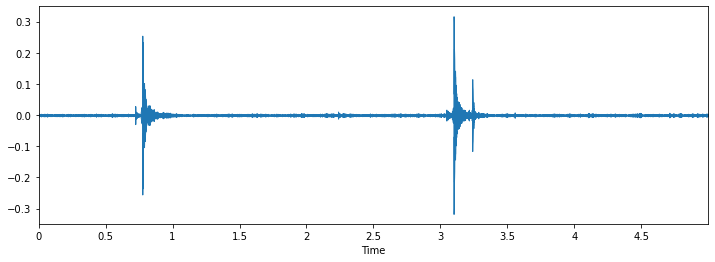

In [8]:
# loading sample audio to visualize its patterns
#water drop sound
filename = 'sample audio/1-12654-B-15.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

In [9]:
#importing csv file for the classes
import pandas as pd
metadata = pd.read_csv('esc50.csv')
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [11]:
#class distribution
print(metadata.category.value_counts())

breathing           40
frog                40
wind                40
sea_waves           40
crickets            40
door_wood_creaks    40
car_horn            40
mouse_click         40
hand_saw            40
siren               40
hen                 40
helicopter          40
clock_tick          40
rooster             40
engine              40
clock_alarm         40
brushing_teeth      40
cat                 40
chirping_birds      40
train               40
thunderstorm        40
clapping            40
footsteps           40
snoring             40
sheep               40
washing_machine     40
crackling_fire      40
insects             40
crying_baby         40
pouring_water       40
vacuum_cleaner      40
can_opening         40
door_wood_knock     40
water_drops         40
dog                 40
church_bells        40
laughing            40
pig                 40
crow                40
keyboard_typing     40
coughing            40
drinking_sipping    40
chainsaw            40
sneezing   

### Iterate through each audio file and extract, number of audio channels, sample rate and bit-depth.

In [18]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display

from helpers.wavfilehelper import WavFileHelper
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath('sample audio'),str(row["filename"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [19]:
# num of channels 

print(audiodf.num_channels.value_counts(normalize=True))

1    1.0
Name: num_channels, dtype: float64


In [20]:
# sample rates 

print(audiodf.sample_rate.value_counts(normalize=True))

16000    1.0
Name: sample_rate, dtype: float64


In [21]:
# bit depth

print(audiodf.bit_depth.value_counts(normalize=True))

16    1.0
Name: bit_depth, dtype: float64


## Extracting a MFCC
#### For this we will use Librosa's mfcc() function which generates an MFCC from time series audio data.

In [35]:
import librosa 
import numpy as np

#lets find mfcc for one file only

filename = 'sample audio/1-137-A-32.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 

mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 216)


the above output shows that librosa calculated a series of 40 MFCCs over 216 frames.

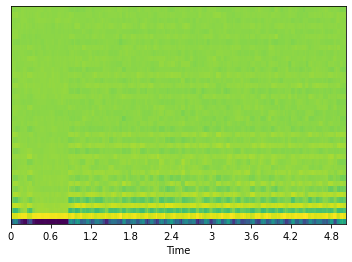

In [37]:
#showing mfccs of the given sample  (class= keyboard typing)
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time', cmap='viridis')

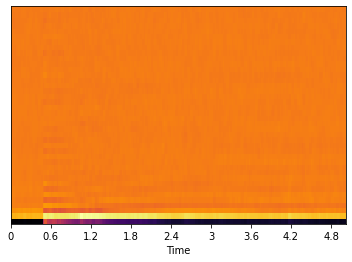

In [38]:
#lets try another sample
filename = 'sample audio/1-115545-C-48.wav' 
librosa_audio, librosa_sample_rate = librosa.load(filename) 

mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time', cmap='inferno')

In [39]:
#function to extract MFCC for all files

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [40]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = 'sample audio'

metadata = pd.read_csv('esc50.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),str(row["filename"]))
    
    class_label = row["category"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  2000  files


### Convert the data and labels

We will use `sklearn.preprocessing.LabelEncoder` to encode the categorical text data into model-understandable numerical data. 

In [41]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

Using TensorFlow backend.


### Split the dataset

Here we will use `sklearn.model_selection.train_test_split` to split the dataset into training and testing sets. The testing set size will be 20% and we will set a random state. 


In [42]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [43]:
### store the preprocessed data for training

%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)
